In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets, model_selection, metrics
import xgboost as xgb
import lightgbm as lgb
import statsmodels.api as sm
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import geopandas as gpd
import requests
from dotenv import load_dotenv
from fastapi import FastAPI
import uvicorn
import streamlit as st

c:\sih\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
dates = pd.date_range(start="2023-01-01", end="2024-12-31", freq="D")

markets = ["Coimbatore", "chennai", "tiruppur", "salem", "erode"]
commodities = ["Banana", "Onion", "Maize"]

data = []
np.random.seed(0)  

for date in dates:
    for market in markets:
        for crop in commodities:
            price = {
                "Min Price/Kg": np.random.randint(15, 30),
                "Modal Price/Kg": np.random.randint(30, 50),
                "Max Price/Kg": np.random.randint(50, 100)
            }
            data.append({
                "Date": date,
                "Market": market,
                "Commodity": crop,
                **price
            })

# 4. Create DataFrame
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Preview the synthetic dataset
print(df.head())
print("\nTotal records:", len(df))

        Date      Market Commodity  Min Price/Kg  Modal Price/Kg  Max Price/Kg
0 2023-01-01  Coimbatore    Banana            27              45            50
1 2023-01-01  Coimbatore     Onion            18              33            89
2 2023-01-01  Coimbatore     Maize            24              49            71
3 2023-01-01     chennai    Banana            17              34            73
4 2023-01-01     chennai     Onion            21              42            51

Total records: 10965


In [11]:
df

,Date,Market,Commodity,Min Price/Kg,Modal Price/Kg,Max Price/Kg
0,2023-01-01,Coimbatore,Banana,27,45,50
1,2023-01-01,Coimbatore,Onion,18,33,89
2,2023-01-01,Coimbatore,Maize,24,49,71
3,2023-01-01,chennai,Banana,17,34,73
4,2023-01-01,chennai,Onion,21,42,51
...,...,...,...,...,...,...
10960,2024-12-31,salem,Onion,16,40,69
10961,2024-12-31,salem,Maize,24,38,64
10962,2024-12-31,erode,Banana,25,39,55
10963,2024-12-31,erode,Onion,18,38,65


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10965 entries, 0 to 10964
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            10965 non-null  datetime64[ns]
 1   Market          10965 non-null  object        
 2   Commodity       10965 non-null  object        
 3   Min Price/Kg    10965 non-null  int64         
 4   Modal Price/Kg  10965 non-null  int64         
 5   Max Price/Kg    10965 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 514.1+ KB


In [13]:
df.describe()

,Date,Min Price/Kg,Modal Price/Kg,Max Price/Kg
count,10965,10965.000000,10965.000000,10965.000000
mean,2024-01-01 00:00:00,22.027451,39.487095,74.818513
min,2023-01-01 00:00:00,15.000000,30.000000,50.000000
25%,2023-07-02 00:00:00,18.000000,34.000000,62.000000
50%,2024-01-01 00:00:00,22.000000,40.000000,75.000000
75%,2024-07-02 00:00:00,26.000000,44.000000,87.000000
max,2024-12-31 00:00:00,29.000000,49.000000,99.000000
std,NaN,4.320783,5.752079,14.456526


In [14]:
df["Date"] = pd.to_datetime(df["Date"])

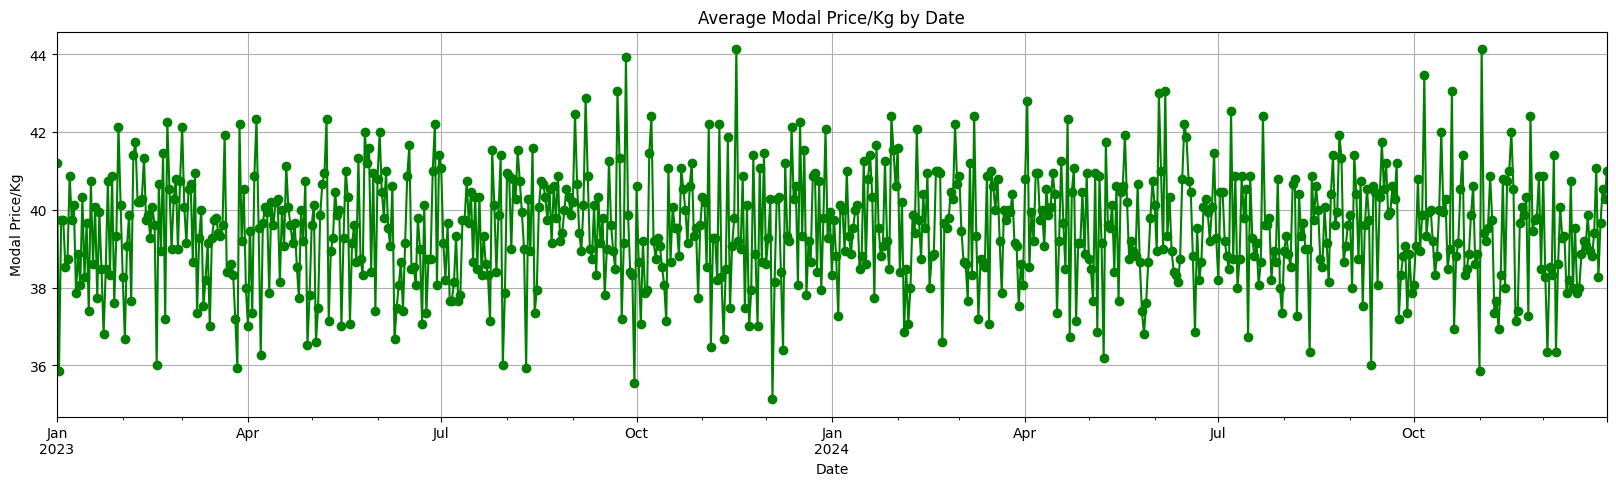

In [19]:
plt.figure(figsize=(20,5))
df.groupby("Date")["Modal Price/Kg"].mean().plot(kind="line", marker="o", color="green")
plt.title("Average Modal Price/Kg by Date")
plt.xlabel("Date")
plt.ylabel("Modal Price/Kg")
plt.grid(True)
plt.show()

Regression Model MAE: 4.90 INR


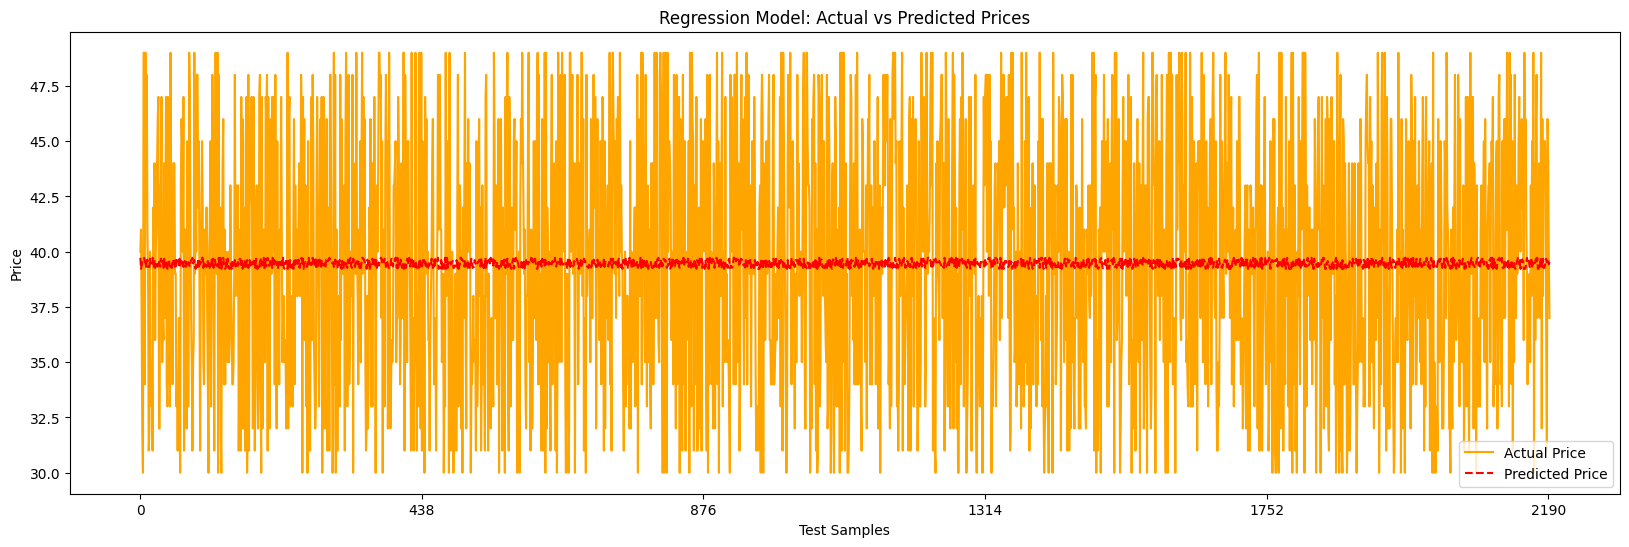

In [26]:
# ...existing code...
# Encode categorical features
X = pd.get_dummies(df[['Market', 'Commodity']])

y = df['Modal Price/Kg']

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Regression Model MAE: {mae:.2f} INR")

plt.figure(figsize=(20,6))
plt.plot(range(len(y_test)), y_test.values, label="Actual Price", color='orange')
plt.plot(range(len(y_pred)), y_pred, label="Predicted Price", linestyle='--', color='red')
plt.title("Regression Model: Actual vs Predicted Prices")
plt.xlabel("Test Samples")
plt.ylabel("Price")
plt.legend()
step = max(1, len(y_test)//5)  # Show about 10 labels
plt.xticks(range(0, len(y_test), step))
plt.show()

XGBoost Model MAE: 4.91 INR


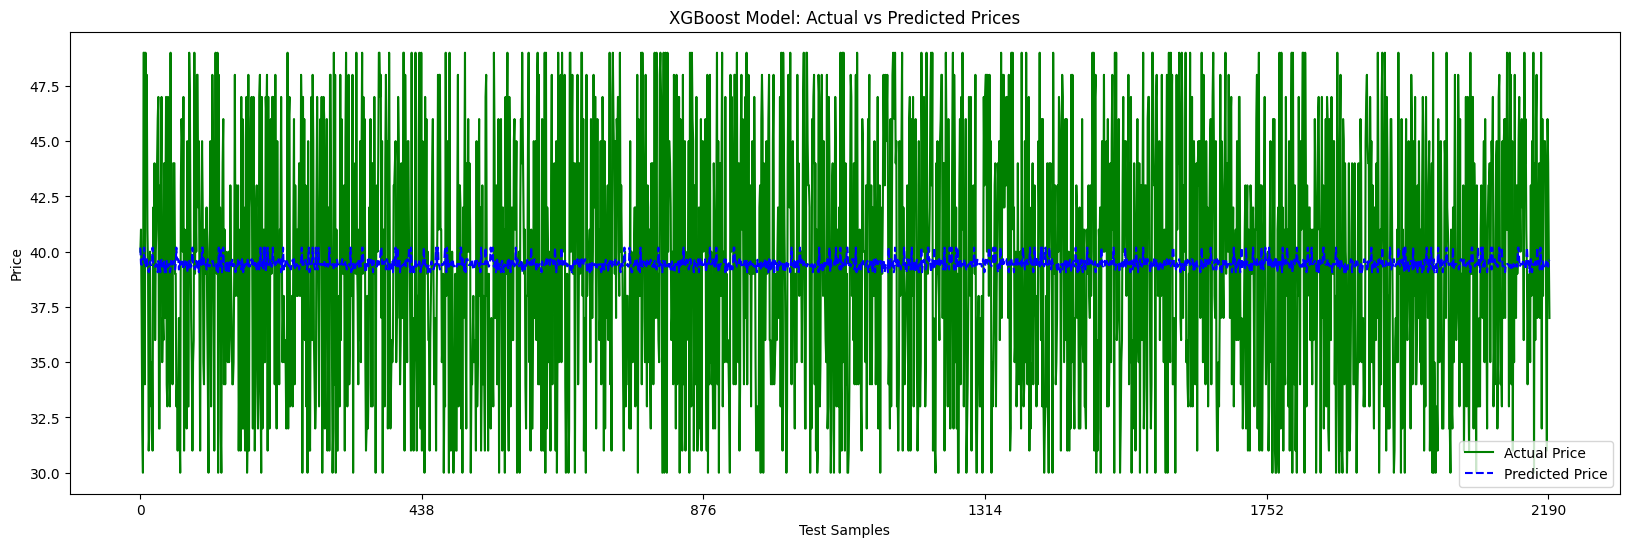

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Encode categorical features
X = pd.get_dummies(df[['Market', 'Commodity']])
y = df['Modal Price/Kg']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost Model MAE: {mae:.2f} INR")

# Plot actual vs predicted
plt.figure(figsize=(20,6))
plt.plot(range(len(y_test)), y_test.values, label="Actual Price", color='green')
plt.plot(range(len(y_pred)), y_pred, label="Predicted Price", linestyle='--', color='blue')
plt.title("XGBoost Model: Actual vs Predicted Prices")
plt.xlabel("Test Samples")
plt.ylabel("Price")
plt.legend()
step = max(1, len(y_test)//5)
plt.xticks(range(0, len(y_test), step))
plt.show()

C:\Users\sanjeevnath\AppData\Local\Temp\ipykernel_19204\1919104666.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Modal Price/Kg'].mean().reset_index()
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

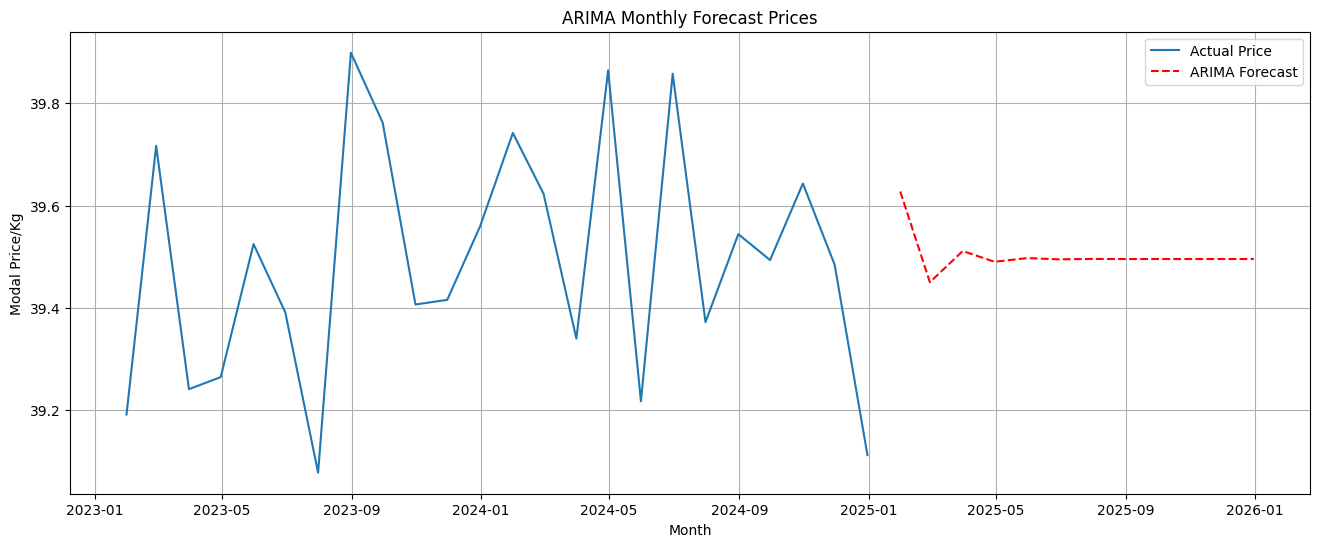

ARIMA Forecast for next 12 months:
2025-01: 39.63
2025-02: 39.45
2025-03: 39.51
2025-04: 39.49
2025-05: 39.50
2025-06: 39.49
2025-07: 39.50
2025-08: 39.50
2025-09: 39.50
2025-10: 39.50
2025-11: 39.50
2025-12: 39.50


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Modal Price/Kg'].mean().reset_index()
monthly_df.set_index('Date', inplace=True)

# ARIMA model (monthly)
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(monthly_df['Modal Price/Kg'], order=(1,1,1))
arima_fit = arima_model.fit()
arima_forecast_steps = 12  # Predict next 12 months
arima_forecast = arima_fit.forecast(steps=arima_forecast_steps)
arima_future_months = pd.date_range(start=monthly_df.index[-1] + pd.DateOffset(months=1), periods=arima_forecast_steps, freq='M')

plt.figure(figsize=(16,6))
plt.plot(monthly_df.index, monthly_df['Modal Price/Kg'], label="Actual Price")
plt.plot(arima_future_months, arima_forecast, label="ARIMA Forecast", linestyle='--', color='red')
plt.title("ARIMA Monthly Forecast Prices")
plt.xlabel("Month")
plt.ylabel("Modal Price/Kg")
plt.legend()
plt.grid(True)
plt.show()

print("ARIMA Forecast for next 12 months:")
for date, value in zip(arima_future_months, arima_forecast):
    print(f"{date.strftime('%Y-%m')}: {value:.2f}")

C:\Users\sanjeevnath\AppData\Local\Temp\ipykernel_19204\2229354955.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Modal Price/Kg'].mean().reset_index()
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\sih\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\sih\.venv\Lib\site-packages\statsmodels\base\model.py:60

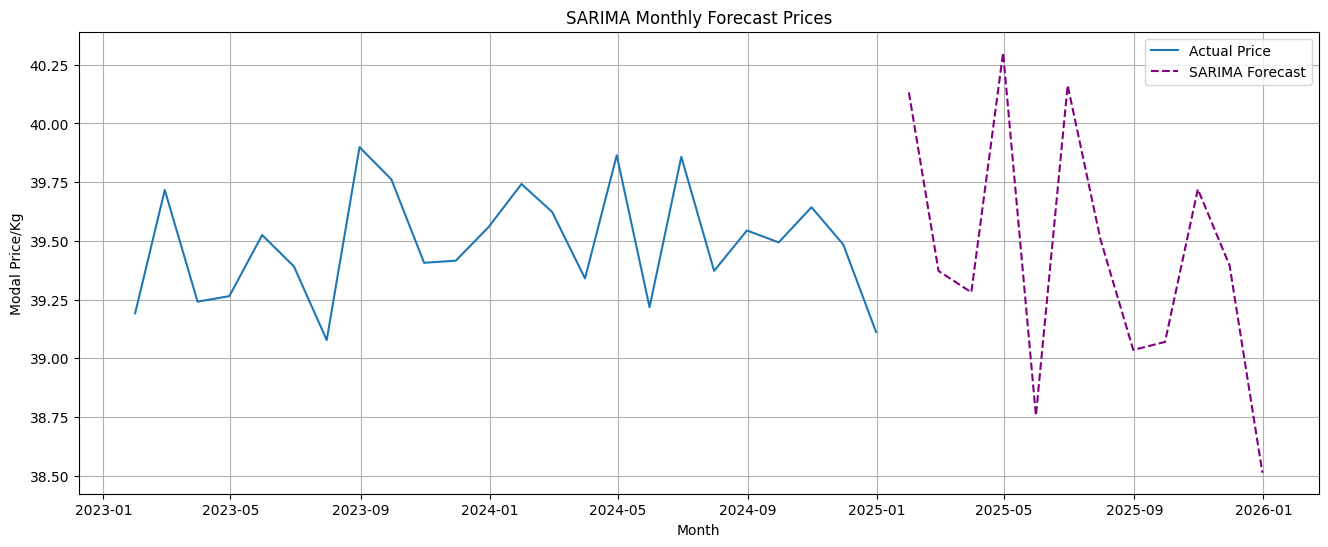

SARIMA Forecast for next 12 months:
2025-01: 40.13
2025-02: 39.37
2025-03: 39.28
2025-04: 40.30
2025-05: 38.76
2025-06: 40.16
2025-07: 39.51
2025-08: 39.04
2025-09: 39.07
2025-10: 39.72
2025-11: 39.39
2025-12: 38.51


In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare monthly average price data
df['Date'] = pd.to_datetime(df['Date'])
monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))['Modal Price/Kg'].mean().reset_index()
monthly_df.set_index('Date', inplace=True)

# SARIMA model (example order and seasonal_order, tune as needed)
sarima_model = SARIMAX(monthly_df['Modal Price/Kg'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
forecast_steps = 12  # Predict next 12 months
sarima_forecast = sarima_fit.forecast(steps=forecast_steps)

# Generate future months for x-axis
last_month = monthly_df.index[-1]
future_months = pd.date_range(start=last_month + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

plt.figure(figsize=(16,6))
plt.plot(monthly_df.index, monthly_df['Modal Price/Kg'], label="Actual Price")
plt.plot(future_months, sarima_forecast, label="SARIMA Forecast", linestyle='--', color='purple')
plt.title("SARIMA Monthly Forecast Prices")
plt.xlabel("Month")
plt.ylabel("Modal Price/Kg")
plt.legend()
plt.grid(True)
plt.show()

print("SARIMA Forecast for next 12 months:")
for date, value in zip(future_months, sarima_forecast):
    print(f"{date.strftime('%Y-%m')}: {value:.2f}")